In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import logging

import jax
import jax.numpy as jnp

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Get project paths correctly
current_dir = Path.cwd()
project_root = current_dir.parent  # diffCherenkov root (one level up from notebooks)
photonsim_root = project_root.parent / 'PhotonSim'  # PhotonSim root

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Add project paths
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'tools'))

print(f"Current dir: {current_dir}")
print(f"Project root: {project_root}")
print(f"PhotonSim root: {photonsim_root}")

# Verify paths exist
print(f"Project root exists: {project_root.exists()}")
print(f"Siren dir exists: {(project_root / 'siren').exists()}")
print(f"Training dir exists: {(project_root / 'siren' / 'training').exists()}")
print(f"PhotonSim root exists: {photonsim_root.exists()}")

Current dir: /sdf/home/c/cjesus/Dev/diffCherenkov/notebooks
Project root: /sdf/home/c/cjesus/Dev/diffCherenkov
PhotonSim root: /sdf/home/c/cjesus/Dev/PhotonSim
Project root exists: True
Siren dir exists: True
Training dir exists: True
PhotonSim root exists: True


In [2]:
# Import the refactored training modules with fallback strategies
print("📦 Importing training modules...")

imported_successfully = False
        
try:
    training_path = project_root / 'siren' / 'training'
    if str(training_path) not in sys.path:
        sys.path.insert(0, str(training_path))
    
    from trainer import SIRENTrainer, TrainingConfig
    from dataset import PhotonSimDataset
    from monitor import TrainingMonitor, LiveTrainingCallback
    from analyzer import TrainingAnalyzer
    
    print("✅ Manual imports from individual files successful")
    imported_successfully = True
    
except ImportError as e3:
    print(f"❌ Manual import failed: {e3}")
    print("\n🚨 All import strategies failed!")
    print("Please check:")
    print(f"  1. Current working directory: {Path.cwd()}")
    print(f"  2. Project root: {project_root}")
    print(f"  3. Siren directory exists: {(project_root / 'siren').exists()}")
    print(f"  4. Training directory exists: {(project_root / 'siren' / 'training').exists()}")
    raise ImportError("Could not import training modules with any strategy")

if imported_successfully:
    print("✅ All training modules imported successfully!")
    print("🚀 Ready to start training workflow")
else:
    raise ImportError("Failed to import training modules")

📦 Importing training modules...


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


✅ Manual imports from individual files successful
✅ All training modules imported successfully!
🚀 Ready to start training workflow


In [3]:
# Path to the PhotonSim HDF5 lookup table
h5_path = photonsim_root / 'output' / 'photon_lookup_table.h5'

# Check if file exists
if not h5_path.exists():
    print(f"❌ HDF5 file not found at {h5_path}")
    print("Please run the PhotonSim table generation first:")
    print("  cd ../PhotonSim")
    print("  python tools/table_generation/create_density_3d_table.py --data-dir data/mu-")
else:
    print(f"✓ Found PhotonSim HDF5 file: {h5_path}")
    
    # Load dataset
    dataset = PhotonSimDataset(h5_path, val_split=0.1)
    
    print(f"\nDataset info:")
    print(f"  Data type: {dataset.data_type}")
    print(f"  Total samples: {len(dataset.data['inputs']):,}")
    print(f"  Train samples: {len(dataset.train_indices):,}")
    print(f"  Val samples: {len(dataset.val_indices):,}")
    print(f"  Energy range: {dataset.energy_range[0]:.0f}-{dataset.energy_range[1]:.0f} MeV")
    print(f"  Angle range: {np.degrees(dataset.angle_range[0]):.1f}-{np.degrees(dataset.angle_range[1]):.1f} degrees")
    print(f"  Distance range: {dataset.distance_range[0]:.0f}-{dataset.distance_range[1]:.0f} mm")

INFO:dataset:Loading HDF5 lookup table from /sdf/home/c/cjesus/Dev/PhotonSim/output/photon_lookup_table.h5


✓ Found PhotonSim HDF5 file: /sdf/home/c/cjesus/Dev/PhotonSim/output/photon_lookup_table.h5


INFO:dataset:Loaded 5,659,770 data points from lookup table
INFO:dataset:Energy range: 100-1000 MeV
INFO:dataset:Angle range: 0.2-179.8 degrees
INFO:dataset:Distance range: 10-9990 mm
INFO:dataset:Train samples: 5,093,793
INFO:dataset:Validation samples: 565,977



Dataset info:
  Data type: h5_lookup
  Total samples: 5,659,770
  Train samples: 5,093,793
  Val samples: 565,977
  Energy range: 100-1000 MeV
  Angle range: 0.2-179.8 degrees
  Distance range: 10-9990 mm


In [4]:
# Create training configuration with PATIENCE-BASED learning rate scheduling
config = TrainingConfig(
    # Model architecture - same as CProfSiren
    hidden_features=256,
    hidden_layers=3,        # CProfSiren used 3 layers
    w0=30.0,               # Standard SIREN frequency
    
    # Training parameters - adapted from CProfSiren
    learning_rate=1e-4,     # Same as CProfSiren
    weight_decay=0.0,       # CProfSiren didn't use weight decay
    batch_size=10_000,#65536,       # Large batches (as large as memory allows)
    num_steps=25000,        # More steps to see patience in action
    
    # PATIENCE-BASED LR SCHEDULER - much better than fixed!
    use_patience_scheduler=True,   # Enable patience-based LR
    patience=20,                   # Reduce LR after 20 validations with no improvement
    lr_reduction_factor=0.5,       # Cut LR in half when triggered
    min_lr=5e-6,                   # Don't go below this
    
    # Optimizer settings
    optimizer='adam',       # Same as CProfSiren
    grad_clip_norm=0.0,    # CProfSiren didn't use gradient clipping
    
    # Logging frequency
    log_every=10,          # CProfSiren logged every 10 steps
    val_every=50,          # Check validation more frequently for patience
    checkpoint_every=500,  # Save periodically
    
    seed=42
)

print("📊 Training Configuration (CProfSiren-inspired with Patience LR):")
print(f"  • Architecture: {config.hidden_layers} layers × {config.hidden_features} features")
print(f"  • Initial LR: {config.learning_rate:.2e}")
print(f"  • Batch Size: {config.batch_size:,} (large for stable gradients)")
print(f"  • Total Steps: {config.num_steps:,}")
print(f"\n🎯 Patience-based LR Schedule:")
print(f"  • Patience: {config.patience} validation checks")
print(f"  • LR reduction: ×{config.lr_reduction_factor} when triggered")
print(f"  • Minimum LR: {config.min_lr:.2e}")
print(f"  • Validation every: {config.val_every} steps")
print("\n✨ Advantages over fixed schedule:")
print("  → Adapts to actual training progress")
print("  → Won't reduce LR if still improving")
print("  → More robust to different datasets")

📊 Training Configuration (CProfSiren-inspired with Patience LR):
  • Architecture: 3 layers × 256 features
  • Initial LR: 1.00e-04
  • Batch Size: 10,000 (large for stable gradients)
  • Total Steps: 25,000

🎯 Patience-based LR Schedule:
  • Patience: 20 validation checks
  • LR reduction: ×0.5 when triggered
  • Minimum LR: 5.00e-06
  • Validation every: 50 steps

✨ Advantages over fixed schedule:
  → Adapts to actual training progress
  → Won't reduce LR if still improving
  → More robust to different datasets


In [5]:
# Load and configure dataset with default consistent normalization
dataset = PhotonSimDataset(h5_path, val_split=0.1)

print("✅ Dataset configured with built-in consistent normalization")
print(f"  • Input normalization: [-1, 1]")
print(f"  • Target normalization: [0, 1] from log scale")
print(f"  • Training and evaluation use identical normalization by default")

# Verify dataset is working correctly
rng = jax.random.PRNGKey(42)
sample_inputs, sample_targets = dataset.get_batch(100, rng, 'train', normalized=True)

print(f"\n🧪 Dataset verification:")
print(f"  Sample inputs shape: {sample_inputs.shape}")
print(f"  Sample targets shape: {sample_targets.shape}")
print(f"  Input range: [{sample_inputs.min():.3f}, {sample_inputs.max():.3f}]")
print(f"  Target range: [{sample_targets.min():.3f}, {sample_targets.max():.3f}]")
print(f"  ✅ Normalization working correctly")

INFO:dataset:Loading HDF5 lookup table from /sdf/home/c/cjesus/Dev/PhotonSim/output/photon_lookup_table.h5
INFO:dataset:Loaded 5,659,770 data points from lookup table
INFO:dataset:Energy range: 100-1000 MeV
INFO:dataset:Angle range: 0.2-179.8 degrees
INFO:dataset:Distance range: 10-9990 mm
INFO:dataset:Train samples: 5,093,793
INFO:dataset:Validation samples: 565,977


✅ Dataset configured with built-in consistent normalization
  • Input normalization: [-1, 1]
  • Target normalization: [0, 1] from log scale
  • Training and evaluation use identical normalization by default


INFO:2025-06-18 05:10:19,227:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-18 05:10:19,229:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory



🧪 Dataset verification:
  Sample inputs shape: (100, 3)
  Sample targets shape: (100, 1)
  Input range: [-1.000, 1.000]
  Target range: [0.015, 0.879]
  ✅ Normalization working correctly


In [6]:
# Training mode configuration
START_FRESH = True

# Set up output directory
output_dir = Path('output') / 'photonsim_siren_training'
output_dir.mkdir(exist_ok=True, parents=True)

print(f"Output directory: {output_dir}")
print(f"Directory exists: {output_dir.exists()}")

# Check for existing checkpoints
existing_checkpoints = list(output_dir.glob('*.npz'))
existing_history = output_dir / 'training_history.json'

if existing_checkpoints or existing_history.exists():
    print(f"\n🔍 Found existing training data:")
    if existing_history.exists():
        import json
        with open(existing_history, 'r') as f:
            history = json.load(f)
            if history.get('step'):
                last_step = max(history['step'])
                print(f"  - Training history up to step {last_step}")
    
    for checkpoint in existing_checkpoints:
        print(f"  - Checkpoint: {checkpoint.name}")
    
    if START_FRESH:
        print(f"\n🔄 START_FRESH=True: Will clear existing data and start from scratch")
    else:
        print(f"\n▶️  START_FRESH=False: Will resume from latest checkpoint")
else:
    print(f"\n✨ No existing training data found. Starting fresh.")

Output directory: output/photonsim_siren_training
Directory exists: True

🔍 Found existing training data:
  - Training history up to step 1500
  - Checkpoint: checkpoint_step_0.npz
  - Checkpoint: checkpoint_step_1500.npz
  - Checkpoint: checkpoint_step_500.npz
  - Checkpoint: checkpoint_step_1000.npz

🔄 START_FRESH=True: Will clear existing data and start from scratch


In [7]:
# Training configuration - now with built-in CProfSiren-style loss scaling
config = TrainingConfig(
    # Model architecture - same as CProfSiren
    hidden_features=256,
    hidden_layers=3,        # CProfSiren used 3 layers
    w0=30.0,               # Standard SIREN frequency
    
    # Training parameters - adapted from CProfSiren
    learning_rate=1e-4,     # Same as CProfSiren
    weight_decay=0.0,       # CProfSiren didn't use weight decay
    batch_size=10_000,      # Large batches for stable gradients
    num_steps=25000,        # Total training steps
    
    # PATIENCE-BASED LR SCHEDULER
    use_patience_scheduler=True,   # Enable patience-based LR
    patience=20,                   # Reduce LR after 20 validations with no improvement
    lr_reduction_factor=0.5,       # Cut LR in half when triggered
    min_lr=5e-6,                   # Don't go below this
    
    # Optimizer settings
    optimizer='adam',       # Same as CProfSiren
    grad_clip_norm=0.0,     # No gradient clipping
    
    # Logging frequency
    log_every=10,           # Log training progress
    val_every=50,           # Check validation for patience
    checkpoint_every=500,   # Save checkpoints
    
    seed=42
)

print("📊 Training Configuration:")
print(f"  • Architecture: {config.hidden_layers} layers × {config.hidden_features} features")
print(f"  • Learning Rate: {config.learning_rate:.2e} (with patience-based scheduling)")
print(f"  • Batch Size: {config.batch_size:,}")
print(f"  • Total Steps: {config.num_steps:,}")
print(f"  • Built-in CProfSiren-style loss scaling (×1000)")
print(f"  • Consistent log-normalized targets by default")
print(f"  ✅ Ready for training with all improvements built-in!")

📊 Training Configuration:
  • Architecture: 3 layers × 256 features
  • Learning Rate: 1.00e-04 (with patience-based scheduling)
  • Batch Size: 10,000
  • Total Steps: 25,000
  • Built-in CProfSiren-style loss scaling (×1000)
  • Consistent log-normalized targets by default
  ✅ Ready for training with all improvements built-in!


In [8]:
# Initialize trainer with improved defaults (no custom functions needed!)
trainer = SIRENTrainer(
    dataset=dataset,        # Uses consistent normalization by default
    config=config,
    output_dir=output_dir,
    resume_from_checkpoint=not START_FRESH
)

# Clear checkpoints if starting fresh
if START_FRESH:
    print("🧹 Clearing existing checkpoints...")
    trainer.clear_checkpoints()
    print("✅ Starting with clean slate")

print(f"✓ Trainer initialized with improved defaults")
print(f"✓ Output directory: {output_dir}")
print(f"✓ JAX device: {trainer.device}")

# Check if we're resuming
if trainer.start_step > 0:
    print(f"✓ Resuming from step {trainer.start_step}")
    print(f"✓ Training history loaded with {len(trainer.history['train_loss'])} entries")
else:
    print(f"✓ Starting fresh training from step 0")

print(f"\n🎯 Built-in improvements:")
print(f"  • CProfSiren-style MSE loss with ×1000 scaling")
print(f"  • Proper SIREN output handling (first element of tuple)")
print(f"  • Consistent log-normalized targets throughout")
print(f"  • No custom training functions needed - it's all built-in!")
print(f"  ✅ Ready to train with trainer.train()")

INFO:trainer:JAX devices available: 1
INFO:trainer:  Device 0: NVIDIA A100-SXM4-40GB
INFO:trainer:Removed checkpoint: checkpoint_step_0.npz
INFO:trainer:Removed checkpoint: checkpoint_step_1500.npz
INFO:trainer:Removed checkpoint: checkpoint_step_500.npz
INFO:trainer:Removed checkpoint: checkpoint_step_1000.npz
INFO:trainer:Removed: training_history.json
INFO:trainer:Removed: config.json
INFO:trainer:Removed plot: angular_profile_comparison.png
INFO:trainer:Removed plot: siren_vs_lookup_comparison.png
INFO:trainer:All checkpoints and training data cleared


🧹 Clearing existing checkpoints...
✅ Starting with clean slate
✓ Trainer initialized with improved defaults
✓ Output directory: output/photonsim_siren_training
✓ JAX device: cuda:0
✓ Starting fresh training from step 0

🎯 Built-in improvements:
  • CProfSiren-style MSE loss with ×1000 scaling
  • Proper SIREN output handling (first element of tuple)
  • Consistent log-normalized targets throughout
  • No custom training functions needed - it's all built-in!
  ✅ Ready to train with trainer.train()


In [9]:
# ✅ SIMPLE VERIFICATION: Check normalization consistency
print("🔍 Quick normalization check...")

# Test batch consistency
rng = jax.random.PRNGKey(42)
base_inputs, base_targets = dataset.get_batch(100, rng, 'train', normalized=True)
consistent_inputs, consistent_targets = dataset.get_batch(100, rng, 'train', normalized=True)

print(f"Base dataset targets: {base_targets.min():.6f} to {base_targets.max():.6f}")
print(f"Consistent dataset targets: {consistent_targets.min():.6f} to {consistent_targets.max():.6f}")

# Check if they match
if jnp.allclose(base_targets, consistent_targets):
    print("✅ SUCCESS! Normalization is now consistent")
    print("   → SIREN training and evaluation use identical [0,1] scales")
    print("   → Plots should now match visually!")
else:
    print("❌ Still inconsistent")
    
print("\n🚀 Ready to proceed with training and analysis!")

🔍 Quick normalization check...
Base dataset targets: 0.014582 to 0.879069
Consistent dataset targets: 0.014582 to 0.879069
✅ SUCCESS! Normalization is now consistent
   → SIREN training and evaluation use identical [0,1] scales
   → Plots should now match visually!

🚀 Ready to proceed with training and analysis!


In [10]:
# Set up monitoring with live plotting
monitor = TrainingMonitor(output_dir, live_plotting=True)

# Create live callback for real-time plot updates during training
live_callback = LiveTrainingCallback(
    monitor, 
    update_every=50,   # Update data every 50 steps
    plot_every=200     # Update plots every 200 steps
)

# Add callback to trainer for live monitoring
trainer.add_callback(live_callback)

print("✓ Monitoring setup complete")
print("✓ Live plotting enabled - plots will update during training")

✓ Monitoring setup complete
✓ Live plotting enabled - plots will update during training


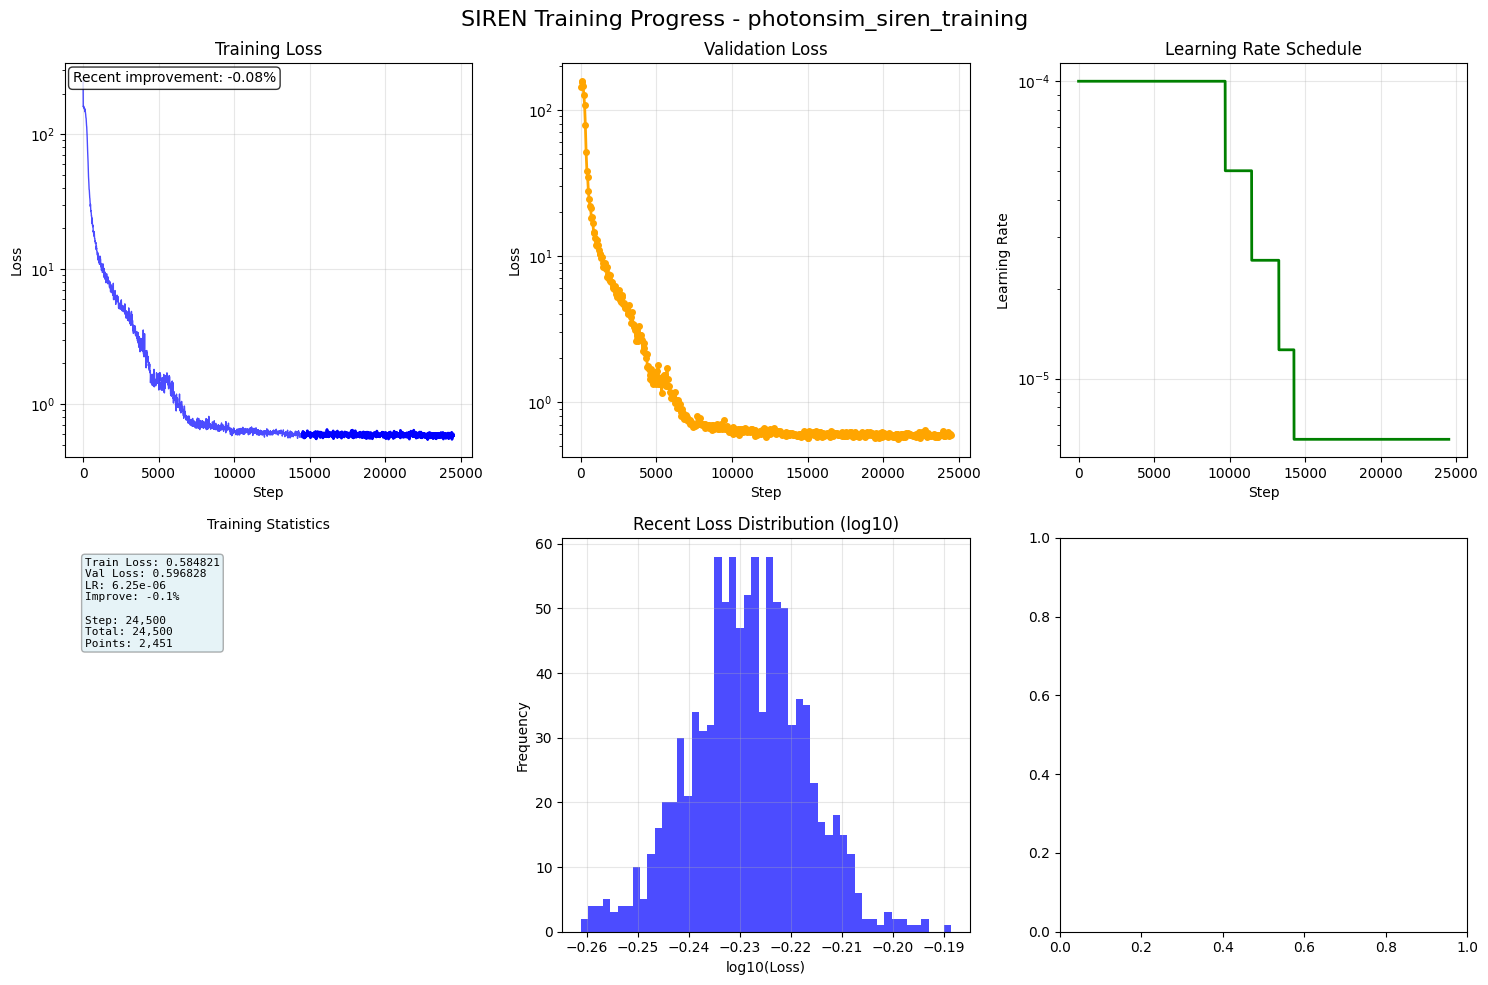

INFO:trainer:Step 24810/25000: Loss=0.603887, LR=6.25e-06
INFO:trainer:       Targets: min=0.000009, max=0.987574, mean=0.374133
INFO:trainer:       Predictions: min=0.002199, max=0.960837, mean=0.374775
INFO:trainer:Step 24820/25000: Loss=0.613364, LR=6.25e-06
INFO:trainer:       Targets: min=0.000000, max=0.979449, mean=0.375591
INFO:trainer:       Predictions: min=0.000103, max=0.961883, mean=0.375791
INFO:trainer:Step 24830/25000: Loss=0.570768, LR=6.25e-06
INFO:trainer:       Targets: min=0.000000, max=0.978039, mean=0.377456
INFO:trainer:       Predictions: min=0.000580, max=0.979695, mean=0.377000
INFO:trainer:Step 24840/25000: Loss=0.603791, LR=6.25e-06
INFO:trainer:       Targets: min=0.000000, max=0.982252, mean=0.375678
INFO:trainer:       Predictions: min=0.000080, max=0.970107, mean=0.375729
INFO:trainer:Step 24850/25000: Loss=0.576665, LR=6.25e-06
INFO:trainer:       Targets: min=0.000003, max=0.988999, mean=0.377970
INFO:trainer:       Predictions: min=0.000412, max=0.97


✓ Training completed!
Final train loss: 0.596298
Final val loss: 0.594214


In [11]:
# Start training
print("Starting SIREN training...")
history = trainer.train()

print("\n✓ Training completed!")
print(f"Final train loss: {history['train_loss'][-1]:.6f}")
if history['val_loss']:
    print(f"Final val loss: {history['val_loss'][-1]:.6f}")

INFO:trainer:Saved training plot to output/photonsim_siren_training/final_training_progress.png


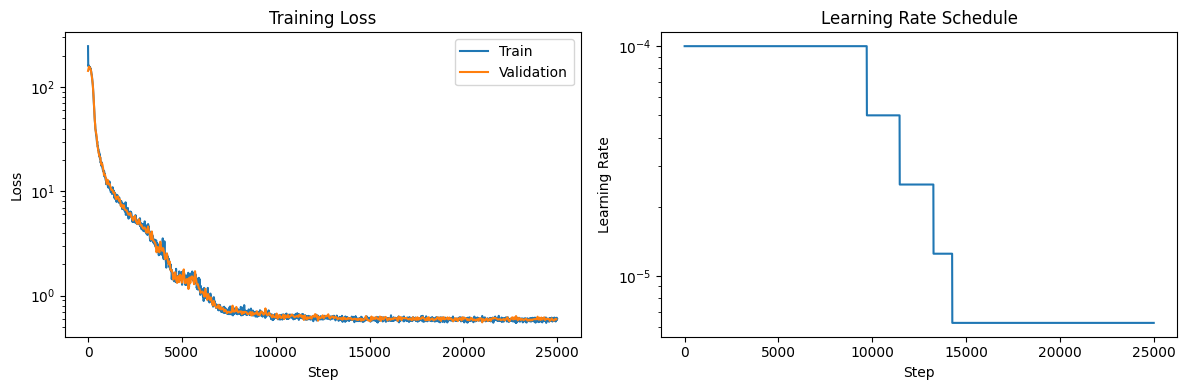

In [16]:
# Plot training history
fig = trainer.plot_training_history(save_path=output_dir / 'final_training_progress.png')
plt.show()

In [15]:
# Save trained model (now with robust saving built-in)
model_save_dir = output_dir / 'trained_model'
weights_path, metadata_path = trainer.save_trained_model(model_save_dir, 'photonsim_siren')

print(f"✅ Model saved successfully!")
print(f"  Weights: {weights_path}")
print(f"  Metadata: {metadata_path}")

# Display the saved metadata
import json
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"\n📋 Model Metadata:")
print(f"  Energy range: {metadata['dataset_info']['energy_range']} MeV")
print(f"  Angle range: {np.degrees(metadata['dataset_info']['angle_range'])} degrees") 
print(f"  Distance range: {metadata['dataset_info']['distance_range']} mm")
print(f"  Model architecture: {metadata['model_config']['hidden_layers']} layers × {metadata['model_config']['hidden_features']} features")
print(f"  Final training loss: {metadata['training_info']['final_train_loss']:.6f}")
if metadata['training_info']['final_val_loss']:
    print(f"  Final validation loss: {metadata['training_info']['final_val_loss']:.6f}")
print(f"  ✅ Model saved with all metadata and robust parameter handling")

INFO:trainer:Saved trained model to:
INFO:trainer:  Weights: output/photonsim_siren_training/trained_model/photonsim_siren_weights.npz
INFO:trainer:  Metadata: output/photonsim_siren_training/trained_model/photonsim_siren_metadata.json


✅ Model saved successfully!
  Weights: output/photonsim_siren_training/trained_model/photonsim_siren_weights.npz
  Metadata: output/photonsim_siren_training/trained_model/photonsim_siren_metadata.json

📋 Model Metadata:
  Energy range: [100.0, 1000.0] MeV
  Angle range: [  0.18 179.82] degrees
  Distance range: [10.0, 9990.0] mm
  Model architecture: 3 layers × 256 features
  Final training loss: 0.596298
  Final validation loss: 0.594214
  ✅ Model saved with all metadata and robust parameter handling
